In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from IPython.display import display, clear_output, FileLinks

import altair as alt
from altair.vega import v5
from IPython.display import HTML
from sklearn import preprocessing
from tqdm.notebook import tqdm
import lightgbm as lgb
import numpy as np
import pandas as pd
import lightgbm as lgb
import glob
import os
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from tqdm.notebook import tqdm
import optuna

import gc, datetime, random

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from collections import defaultdict, Counter

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")
import os



# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [2]:
!ls

__notebook__.ipynb


In [3]:
!mkdir pred_QoE_matfiles
!mkdir plots
!mkdir model_weights_temp



In [4]:
!ls

__notebook__.ipynb  model_weights_temp	plots  pred_QoE_matfiles


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.io        
import plotly.graph_objs as go
from PIL import Image

import sys
sys.path.append('/kaggle/input/lstm-git-repo/lstm_qoe-ef6791471e4ea83c2bee1caff476a84e83477057/LFOVIA_QoE/')

################################################################
def OR(x,y,epsilon):
    outage = []

    for i,val in enumerate(epsilon):
        if(abs(x[i]-y[i]) > val):
            outage.append(i)
    return (len(outage)/float(len(epsilon)))*100



##################################################################
def network_train(no_LSTM_layers,no_LSTM_units,X,Y,no_epochs,batch_size,timesteps,no_feat,loss,opt,X_valid,Y_valid, lr):	
    # Initialization
    min_epochs = 5
    best_epoch_no = 1	
    i = 1
    # Initialize the LSTM network	
    net_ts = network_init(no_LSTM_layers,no_LSTM_units,batch_size,timesteps,no_feat,loss,opt)	# Train over the specified no. of epochs
    j=0
    
    
    
    
    
    fig = plt.figure(figsize=(20,10));ax = fig.add_subplot(1, 1, 1) 
    fig.suptitle("Train - Validation Loss");plt.xlabel('num_epochs', fontsize=12);plt.ylabel('loss', fontsize=12)
    plt.legend(loc=2, prop={'size': 60})
    
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='green', label='train')
    green_patch = mpatches.Patch(color='red', label='val')
    plt.legend(handles=[red_patch, green_patch])
    ax.set_xlim(0, no_epochs+1)
    
    
    best_valid_loss = -1
    
    t_loss = []
    v_loss = []
    
    while i <= no_epochs:
        # Train the network
        history = net_ts.fit(X,Y, epochs=1,batch_size=batch_size,verbose=2,shuffle=False,validation_data=(X_valid, Y_valid))
        current_valid_loss = history.history['val_loss']
        current_training_loss = history.history['loss']   

        t_loss.append(current_training_loss)
        v_loss.append(current_valid_loss)
        
        
        if i == min_epochs:
            best_valid_loss = current_valid_loss
            best_epoch_no = i

            net_ts.save_weights(filepath='../working/model_weights_temp/best_model_weights.hdf5',overwrite=True)
        if i > min_epochs:			
            if current_valid_loss < best_valid_loss:
                j=i
                best_valid_loss = current_valid_loss
                best_epoch_no = i					

                net_ts.save_weights(filepath='../working/model_weights_temp/best_model_weights.hdf5',overwrite=True)		
  
            
        if i - j >= 5:
            j=i
            lr /= 2
            opt = tf.keras.optimizers.Adam(
                    learning_rate=lr,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-07,
                    amsgrad=False,
                    name="Adam",
                )
            net_ts.compile(loss=loss,optimizer=opt)
            
        ax.plot( t_loss, label='train', color='green')
        ax.plot( v_loss, label='val', color='red')
        clear_output(wait = True)
        display(fig)
        print('curr epoch', i, 'best_epoch_no', best_epoch_no, '\nbest_valid_loss', best_valid_loss, '\nbest_valid_loss_epoch', j, '\nlr is ', lr)
        
        
            
        # reset the LSTM states
        net_ts.reset_states()				
        i = i + 1
    net = network_init(no_LSTM_layers,no_LSTM_units,batch_size,1,no_feat,loss,opt)	
    net.load_weights(filepath='../working/model_weights_temp/best_model_weights.hdf5')
    os.remove('../working/model_weights_temp/best_model_weights.hdf5')

    return net

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense,Activation
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.layers.wrappers import TimeDistributed

################################################
def network_init(no_LSTM_layers,no_LSTM_units,batch_size,timesteps,no_feat,loss,opt):
    # define the network
    net = Sequential()
    net.add(LSTM(no_LSTM_units,batch_input_shape=(batch_size, timesteps, no_feat),return_sequences = True, stateful = True))

    if no_LSTM_layers > 1:
        for ii in range(no_LSTM_layers-1):
            net.add(LSTM(no_LSTM_units, return_sequences = True, stateful = True))
    net.add(TimeDistributed(Dense(1,activation='relu')))
    net.compile(loss=loss,optimizer=opt)

    print("initiated")
    return net


# LSTM-QoE code for LFOVIA QoE Database

import os
import shutil
import keras 
import numpy as np
from numpy import random as rnd

from sklearn.metrics import mean_squared_error
from math import sqrt

import scipy.io as sio
from scipy.io import loadmat, savemat
from scipy.stats.stats import pearsonr 
from scipy.stats import spearmanr

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import time
import warnings




#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Main Program %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

warnings.filterwarnings('ignore')

# start the timer
tic = time.clock()

# Initialize the random seed
rnd.seed(4)

############# Inputs ############

# path1 = "QoE_matfiles/"
# path2 = "pred_QoE_matfiles/"
# path3 = "plots/"
# path4 = "model_weights_temp/"

In [6]:

path1 = "../input/lstm-git-repo/lstm_qoe-ef6791471e4ea83c2bee1caff476a84e83477057/LFOVIA_QoE/QoE_matfiles/"
path2 = "pred_QoE_matfiles/"
path3 = "plots/"
path4 = "model_weights_temp/"




if not os.path.exists(path2):
	os.mkdir(path2)

if not os.path.exists(path3):
	os.mkdir(path3)

if not os.path.exists(path4):
	os.mkdir(path4)

dataset_name = 'LFOVIA_QoE'

# loss function
loss = 'mse'

# optimizer
opt = 'adam'


lr = 0.01
# LSTM network initializations
no_LSTM_layers = 4
no_LSTM_units = 22

timesteps = 4
no_epochs = 50
batch_size = 1 # batch size fixed to 1 as the LSTM network is stateful

# Dataset information
no_videos = 36
no_training_videos = 25
no_validation_videos = 10

# no. of input features
no_feat = 1
n_feats = no_feat


# Normalizing factors
score_continuous_max = 100
score_continuous_min = 0

# Normalizing factor for NIQE
STSQ_max = 20
STSQ_min = 0


In [7]:
no_videos = 7
no_of_videos = no_videos
split =  0.80


for i in range(no_of_videos):
    idx = list(range(no_of_videos))
    idx.remove(i)
    trn_idx, val_idx = train_test_split(idx, train_size=split)
    break
TVS = np.array([ [0]*len(trn_idx)  ] * no_of_videos ) 
VVS = np.array([ [0]*len(val_idx)  ] * no_of_videos ) 

for i in range(no_of_videos):
    
    idx = list(range(no_of_videos))
    idx.remove(i)
    
    trn_idx, val_idx = train_test_split(idx, train_size=split)
    
    TVS[i] = np.array(trn_idx)
    VVS[i] = np.array(val_idx)
    
    
no_training_videos = TVS.shape[1]
no_validation_videos = VVS.shape[1]

TVS

array([[6, 1, 3, 2],
       [3, 5, 0, 2],
       [0, 4, 5, 3],
       [5, 2, 1, 6],
       [1, 5, 2, 0],
       [3, 2, 1, 0],
       [2, 3, 5, 0]])

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sums = []
throughput_lists =[]
mat_files_path = '/kaggle/input/livenetflixmetadata/Dataset_Information/Mat_Files/'
for e, mat_path_ in enumerate(os.listdir(mat_files_path)):
    mat_file_path = os.path.join(mat_files_path, mat_path_)
    mat_file = scipy.io.loadmat(mat_file_path)
    sum_new = np.sum(mat_file['throughput_trace_kbps'])
    
    
    if sum_new not in sums:
        sc = MinMaxScaler()
        
        content = (mat_file['throughput_trace_kbps'])
#         content = (content - np.min(content)) / (np.max(content) - np.min(content))
        
        
        throughput_lists.append(content)
        sums.append(sum_new)
        
# throughput_lists
len(throughput_lists)


7

In [9]:
throughput_lists

[array([[1392.1261477 , 1139.87237354,  993.08673267,  682.47833333,
          678.10669111, 1041.3578635 ,  653.67779961,  759.70485437,
          285.93882353,  234.00429752, 1057.52229931, 1158.73246753,
         1505.62597403, 1610.09021956, 1085.84468719, 1015.64752475,
         1368.97662338, 1137.21268583,  779.10857143,  390.9370297 ,
          973.58961039,  715.31428571, 1019.22041217,  983.20998004,
         1083.03555114, 1239.59762376,  735.81029703,  824.05069307,
          539.65194805,  634.51337958,  420.69733333,  717.75584416,
         1047.88503469,  842.32578497, 1641.6       , 1768.11948052,
         1727.41727905, 1479.67462981, 1297.15988083,  884.84544564]]),
 array([[1158.91484759, 1407.16883117, 1239.903667  , 1871.62967359,
         1178.18909812, 1641.6       , 1321.83690476, 2302.5038961 ,
         1783.75445545, 1712.66493506, 1165.14047619, 1554.76886228,
         1549.21558442, 1216.06007905,   35.39601259, 3869.15474957,
         1236.52987013, 1229.42

# normal way

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
n_input = 4
n_feature = 1

In [12]:
data = throughput_lists[0][0]
train, valid = data[: int(0.80*len(data))],  data[int(0.80*len(data)) - n_input:]
# valid, train = data[: int(0.20*len(data))],  data[int(0.80*len(data)) - n_input:]


scaled_train = np.array(train).reshape(-1, 1)
scaled_valid = np.array(valid).reshape(-1, 1)

# scaled_valid

In [13]:
train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)
valid_generator = TimeseriesGenerator(scaled_valid,scaled_valid,length=n_input, batch_size=1)

In [14]:
model = Sequential()


model.add(LSTM(128,activation = 'relu', input_shape= (n_input, n_feature), return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit_generator(train_generator,epochs= 100, validation_data=valid_generator)
model.fit_generator(train_generator,epochs= 50, validation_data=valid_generator)
model.fit_generator(train_generator,epochs= 50, validation_data=valid_generator)

Epoch 1/100
28/28 [==============================] - 4s 49ms/step - loss: 598163.7705 - val_loss: 398879.9688
Epoch 2/100
28/28 [==============================] - 0s 10ms/step - loss: 195159.1719 - val_loss: 374207.5938
Epoch 3/100
28/28 [==============================] - 0s 10ms/step - loss: 258431.0364 - val_loss: 568522.6875
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 252398.0075 - val_loss: 486174.7812
Epoch 5/100
28/28 [==============================] - 0s 10ms/step - loss: 145945.2915 - val_loss: 479963.4062
Epoch 6/100
28/28 [==============================] - 0s 9ms/step - loss: 181677.8494 - val_loss: 513052.3750
Epoch 7/100
28/28 [==============================] - 0s 10ms/step - loss: 197514.4033 - val_loss: 500996.7812
Epoch 8/100
28/28 [==============================] - 0s 10ms/step - loss: 262042.8893 - val_loss: 606261.8125
Epoch 9/100
28/28 [==============================] - 0s 9ms/step - loss: 209434.8060 - val_loss: 451427.2500
Epoch 10/100

<Figure size 1440x720 with 0 Axes>

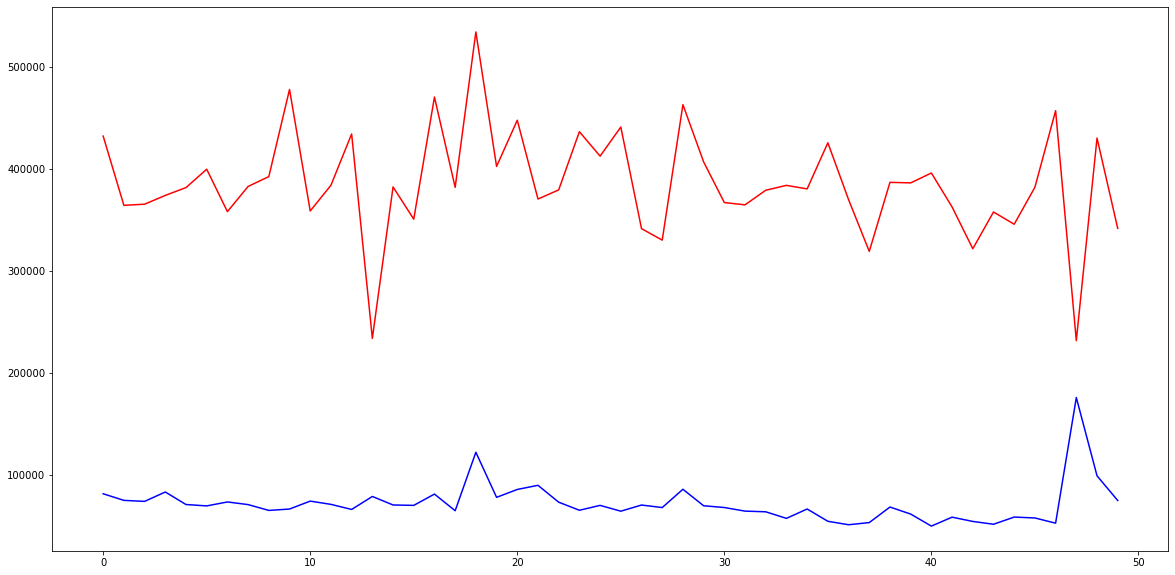

In [17]:
tr_loss= model.history.history['loss']
val_loss= model.history.history['val_loss']

fig = plt.figure(figsize=(20,10));display(fig)
plt.plot(tr_loss, 'b')
plt.plot(val_loss, 'r')

display(fig)

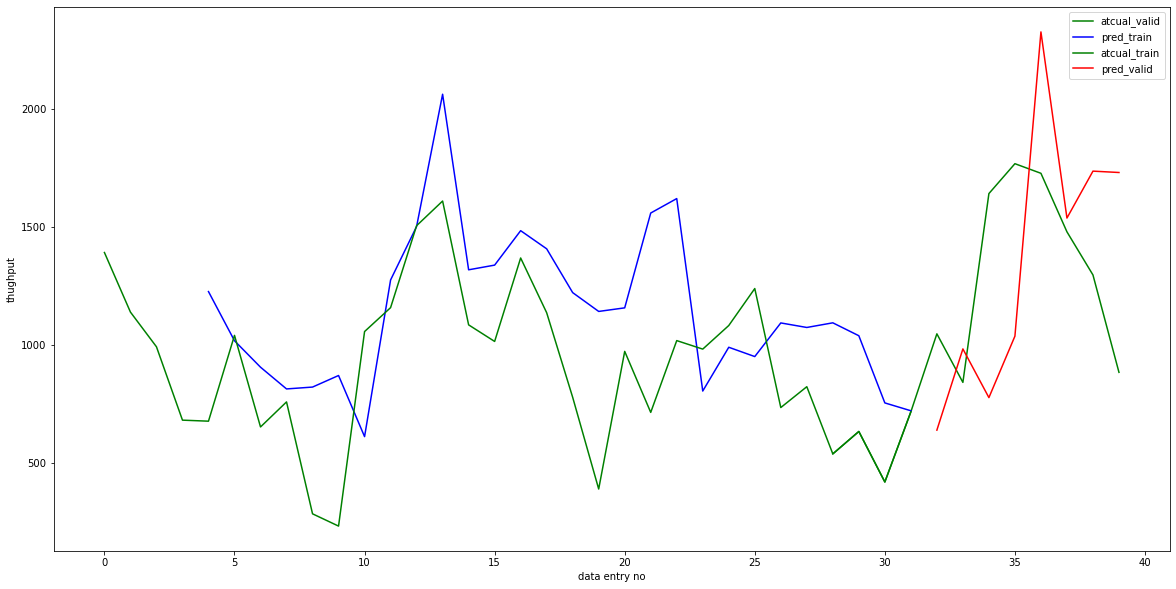

In [18]:
atcual_train = scaled_train[:]
plt_x_train = range(len(atcual_train))
pred_train = model.predict(train_generator)
plt_x_train_p = n_input+np.array(range(len(pred_train)))


atcual_valid = scaled_valid[:]
pred_valid = model.predict(valid_generator)
plt_x_valid = np.array(range(len(atcual_train), len(atcual_train)+len(atcual_valid)))-n_input
plt_x_valid_p = n_input+np.array(range(len(atcual_train), len(atcual_train)+len(pred_valid)))-n_input


fig2 = plt.figure(figsize=(20,10));
plt.plot(plt_x_valid, atcual_valid, 'g')
plt.plot(plt_x_train_p, pred_train, 'b')
plt.plot(plt_x_train, atcual_train, 'g')
plt.plot(plt_x_valid_p, pred_valid, 'r')
plt.xlabel('data entry no')
plt.ylabel('thughput')
plt.legend(["atcual_valid", "pred_train", "atcual_train", "pred_valid"], loc ="upper right") 
e+=1
fig2.savefig(str(e) + '.jpg')
display(fig2)

In [19]:
# model = Sequential()


# model.add(LSTM(128,activation = 'relu', input_shape= (n_input, n_feature), return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=False))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

In [20]:
n_input

4

In [21]:
def model_init(f=0):
    model = Sequential()
    model.add(LSTM(128,activation = 'relu', input_shape= (n_input, n_feature), return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    if f:
        print(model.summary())
    return model

In [22]:
def net_train(all_in_one=1,no_epochs=50,lr=0.01,model=model,train_generator=train_generator,scaled_train=scaled_valid,scaled_valid=scaled_valid):
    
    train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)
    valid_generator = TimeseriesGenerator(scaled_valid,scaled_valid,length=n_input, batch_size=1)
    
    if all_in_one:
        model.fit_generator(train_generator,epochs=no_epochs, validation_data=valid_generator)
        model.fit_generator(train_generator,epochs=no_epochs, validation_data=valid_generator)
        
        my_loss= model.history.history['loss']
        fig1 = plt.figure(figsize=(20,10));display(fig)
        plt.plot(range(len(my_loss)), my_loss)
#         display(fig1)

        atcual_train = scaled_train[:]
        plt_x_train = range(len(atcual_train))
        pred_train = model.predict(train_generator)
        plt_x_train_p = n_input+np.array(range(len(pred_train)))

        atcual_valid = scaled_valid[:]
        pred_valid = model.predict(valid_generator)
        plt_x_valid = np.array(range(len(atcual_train), len(atcual_train)+len(atcual_valid)))-n_input
        plt_x_valid_p = n_input+np.array(range(len(atcual_train), len(atcual_train)+len(pred_valid)))-n_input

        fig2 = plt.figure(figsize=(20,10));
        plt.plot(plt_x_valid, atcual_valid, 'g')
        plt.plot(plt_x_train_p, pred_train, 'b')
        plt.plot(plt_x_train, atcual_train, 'g')
        plt.plot(plt_x_valid_p, pred_valid, 'r')
        plt.xlabel('data entry no')
        plt.ylabel('thughput')
        plt.legend(["atcual_valid", "pred_train", "atcual_train", "pred_valid"], loc ="upper right") 
        e+=1
        fig2.savefig(str(e) + '.jpg')
        display(fig2)
        
        return model, fig1, fig2

    
    min_epochs = 3

    atcual_valid = scaled_valid[n_input:]

    i=0
    j=0
    fig1 = plt.figure(figsize=(20,10));ax = fig1.add_subplot(1, 1, 1) 
    fig1.suptitle("Train - Validation Loss");plt.xlabel('num_epochs', fontsize=12);plt.ylabel('loss', fontsize=12)
    plt.legend(loc=2, prop={'size': 60})

    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='green', label='train')
    green_patch = mpatches.Patch(color='red', label='val')
    plt.legend(handles=[red_patch, green_patch])
    ax.set_xlim(0, no_epochs+1)

    best_epoch_no = -1
    best_valid_loss = -1

    t_loss = []
    v_loss = []


    while i <= no_epochs:
        # Train the network

        model.fit_generator(train_generator,epochs= 1, validation_data=valid_generator)
        current_train_loss= model.history.history['loss']
        current_valid_loss = model.history.history['val_loss']

        v_loss.append(current_valid_loss)
        t_loss.append(current_train_loss)


        if i == min_epochs:
            best_valid_loss = current_valid_loss
            best_epoch_no = i

        if i > min_epochs:			
            if current_valid_loss < best_valid_loss:
                best_valid_loss = current_valid_loss
                best_epoch_no = i					
                j=i

        if i - j >= 5:
            j=i
            lr /= 2
            opt = tf.keras.optimizers.Adam(
                    learning_rate=lr,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-07,
                    amsgrad=False,
                    name="Adam",
                )
            model.compile(loss=loss,optimizer=opt)

        ax.plot( v_loss, label='val', color='red')
        ax.plot( t_loss, label='val', color='green')
        clear_output(wait = True)
        display(fig1)
        print('curr epoch', i, 'best_epoch_no', best_epoch_no,'\ncurrent train loss', current_train_loss, '\nbest_valid_loss', best_valid_loss, '\nbest_valid_loss_epoch', j, '\nlr is ', lr)
        i = i + 1
        
    atcual_train = scaled_train[:]
    plt_x_train = range(len(atcual_train))
    pred_train = model.predict(train_generator)
    plt_x_train_p = n_input+np.array(range(len(pred_train)))


    atcual_valid = scaled_valid[:]
    pred_valid = model.predict(valid_generator)
    plt_x_valid = np.array(range(len(atcual_train), len(atcual_train)+len(atcual_valid)))-n_input
    plt_x_valid_p = n_input+np.array(range(len(atcual_train), len(atcual_train)+len(pred_valid)))-n_input


    fig2 = plt.figure(figsize=(20,10));
    plt.plot(plt_x_valid, atcual_valid, 'g')
    plt.plot(plt_x_train_p, pred_train, 'b')
    plt.plot(plt_x_train, atcual_train, 'g')
    plt.plot(plt_x_valid_p, pred_valid, 'r')
    
    plt.xlabel('data entry no')
    plt.ylabel('thughput')
    plt.legend(["atcual_valid", "pred_train", "atcual_train", "pred_valid"], loc ="upper right") 
    e+=1
    fig2.savefig(str(e) + '.jpg')

    display(fig2)
        
    return model, fig1, fig2

In [23]:
# model, fig1, fig2 = net_train(all_in_one=1,no_epochs=100,lr=0.1,model=model,train_generator=train_generator,scaled_train=scaled_train,scaled_valid=scaled_valid)

In [24]:
# display(fig2)

# combine

Epoch 1/200
28/28 [==============================] - 4s 28ms/step - loss: 673893.2629 - val_loss: 409949.6250
Epoch 2/200
28/28 [==============================] - 0s 10ms/step - loss: 165364.6589 - val_loss: 434376.8750
Epoch 3/200
28/28 [==============================] - 0s 10ms/step - loss: 240501.1412 - val_loss: 557214.5625
Epoch 4/200
28/28 [==============================] - 0s 10ms/step - loss: 222357.8729 - val_loss: 515657.3438
Epoch 5/200
28/28 [==============================] - 0s 10ms/step - loss: 275977.1846 - val_loss: 742413.1250
Epoch 6/200
28/28 [==============================] - 0s 12ms/step - loss: 287856.5150 - val_loss: 546646.8750
Epoch 7/200
28/28 [==============================] - 0s 11ms/step - loss: 220960.5496 - val_loss: 356719.3750
Epoch 8/200
28/28 [==============================] - 0s 10ms/step - loss: 251915.6153 - val_loss: 421656.7500
Epoch 9/200
28/28 [==============================] - 0s 10ms/step - loss: 179523.9232 - val_loss: 631451.8750
Epoch 10/2

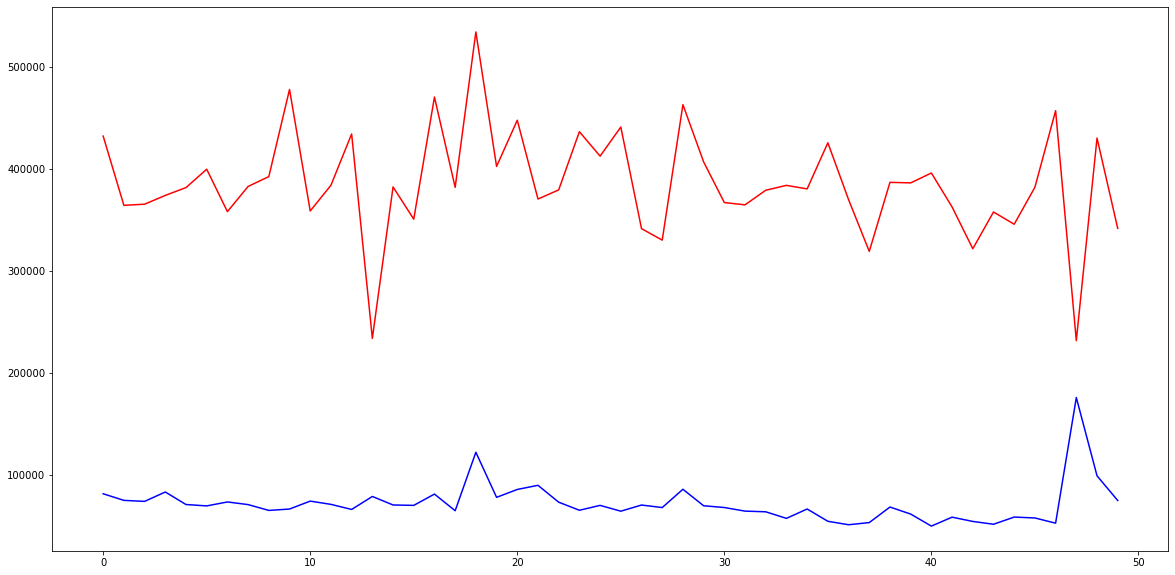

UnboundLocalError: local variable 'e' referenced before assignment

In [25]:
train_datas = []
valid_datas = []

model = model_init()

for throughput_list in throughput_lists:
    
    data = throughput_list[0]
    train, valid = data[: int(0.80*len(data))],  data[int(0.80*len(data)) - n_input:]
    # print(train)
    # print(valid)

    scaled_train = np.array(train).reshape(-1, 1)
    scaled_valid = np.array(valid).reshape(-1, 1)


    train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)
    valid_generator = TimeseriesGenerator(scaled_valid,scaled_valid,length=n_input, batch_size=1)

    
    model, _, _ = net_train(all_in_one=1,no_epochs=200,lr=0.01,model=model,train_generator=train_generator,scaled_train=scaled_train,scaled_valid=scaled_valid)
    
    train_datas.append(scaled_train)
    valid_datas.append(scaled_valid)
        
        
e=0    
for scaled_train, scaled_valid in zip(train_datas, valid_datas):
    train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)
    valid_generator = TimeseriesGenerator(scaled_valid,scaled_valid,length=n_input, batch_size=1)

    atcual_train = scaled_train[:]
    plt_x_train = range(len(atcual_train))
    pred_train = model.predict(train_generator)
    plt_x_train_p = n_input+np.array(range(len(pred_train)))


    atcual_valid = scaled_valid[:]
    pred_valid = model.predict(valid_generator)
    plt_x_valid = np.array(range(len(atcual_train), len(atcual_train)+len(atcual_valid)))-n_input
    plt_x_valid_p = n_input+np.array(range(len(atcual_train), len(atcual_train)+len(pred_valid)))-n_input


    fig2 = plt.figure(figsize=(20,10));
    plt.plot(plt_x_valid, atcual_valid, 'g')
    plt.plot(plt_x_train_p, pred_train, 'b')
    plt.plot(plt_x_train, atcual_train, 'g')
    plt.plot(plt_x_valid_p, pred_valid, 'r')
    
    plt.xlabel('data entry no')
    plt.ylabel('thughput')
    
    plt.legend(["atcual_valid", "pred_train", "atcual_train", "pred_valid"], loc ="upper right") 
    e+=1
    fig2.savefig(str(e) + '.jpg')
    display(fig2)
    

In [26]:
e=0      
for scaled_train, scaled_valid in zip(train_datas, valid_datas):
    train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)
    valid_generator = TimeseriesGenerator(scaled_valid,scaled_valid,length=n_input, batch_size=1)

    atcual_train = scaled_train[:]
    plt_x_train = range(len(atcual_train))
    pred_train = model.predict(train_generator)
    plt_x_train_p = n_input+np.array(range(len(pred_train)))


    atcual_valid = scaled_valid[:]
    pred_valid = model.predict(valid_generator)
    plt_x_valid = np.array(range(len(atcual_train), len(atcual_train)+len(atcual_valid)))-n_input
    plt_x_valid_p = n_input+np.array(range(len(atcual_train), len(atcual_train)+len(pred_valid)))-n_input


    fig2 = plt.figure(figsize=(20,10));
    plt.plot(plt_x_valid, atcual_valid, 'g')
    plt.plot(plt_x_train_p, pred_train, 'b')
    plt.plot(plt_x_train, atcual_train, 'g')
    plt.plot(plt_x_valid_p, pred_valid, 'r')

    plt.xlabel('data entry no')
    plt.ylabel('thughput')
    
    
    plt.legend(["atcual_valid", "pred_train", "atcual_train", "pred_valid"], loc ="upper right") 
    e+=1
    fig2.savefig(str(e) + '.jpg')

    display(fig2)
    
    e+=1
    
    

# Stacked

In [27]:
# # for scaled_valid_sequence, atcual_val in valid_generator:
# #     print(scaled_valid_sequence, atcual_val,  model.predict(scaled_valid_sequence))

# stacked_pred = []
# for scaled_valid_sequence, atcual_val in valid_generator:
# #     scaled_valid_sequence[0][-4][0] = model.predict(scaled_valid_sequence)
#     scaled_valid_sequence[0][-3][0] = model.predict(scaled_valid_sequence)
#     scaled_valid_sequence[0][-2][0] = model.predict(scaled_valid_sequence)
#     scaled_valid_sequence[0][-1][0] = model.predict(scaled_valid_sequence)
    
#     stacked_pred.append(model.predict(scaled_valid_sequence)[0][0])
# # stacked_pred

# # atcual_valid = scaled_valid[n_input:]
# # pred_valid = model.predict(valid_generator)
# fig = plt.figure(figsize=(20,10));
# plt.plot(pred_valid, 'r')
# plt.plot(atcual_valid, 'g')
# plt.plot(stacked_pred, 'b')
# display(fig)

# def doubly_stacked():
    
#     model = net_train(all_in_one=1,no_epochs=100,lr=0.1,model=model,train_generator=train_generator,scaled_train=scaled_valid,scaled_valid=scaled_valid)
    
#     train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)
#     valid_generator = TimeseriesGenerator(scaled_valid,scaled_valid,length=n_input, batch_size=1)
    
#     stacked_pred=[]
#     for scaled_valid_sequence, atcual_val in valid_generator:
#         scaled_valid_sequence[0][-1][0] = model.predict(scaled_valid_sequence)
#         stacked_pred.append(model.predict(scaled_valid_sequence))
        
# #         print(scaled_valid_sequence, atcual_val)
    
    
    


# atcual_train = scaled_train[n_input:]
# pred_train = model.predict(train_generator)
# fig = plt.figure(figsize=(20,10));
# plt.plot(pred_train, 'r')
# plt.plot(atcual_train, 'g')
# display(fig)

# atcual_valid = scaled_valid[n_input:]
# pred_valid = model.predict(valid_generator)
# fig = plt.figure(figsize=(20,10));
# plt.plot(pred_valid, 'r')
# plt.plot(atcual_valid, 'g')
# display(fig)